In [38]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

"""
Own packages
"""
from codelib.dal.fred_yield_data import get_nominal_yield_data

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exercises - Week 2

In this week we will look at a few exercises that show us how to work with the data sets presented in the lectures. 

In this exercies set, we primarily be using `pandas`, `numpy`, `matplotlib.pyplot` and `pandas-datareader`. 

## Problem 1: Asset allocation - what not to do! 

__Note__: Problem is partially based on [Attilio Meucci (2010), "Quant Nugget 2: Linear vs. Compounded Returns – Common Pitfalls in Portfolio Management"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1586656
)

We have learned that we (at least approximately) can treat the log returns on instruments such as equities as invariants. In this problem we explore one potential pitfall when an investor specifies the asset allocation problem. 


__Question 1__

Obtain the equally weighted monthly return data for the five Fama-French industry portfolios ("5_Industry_Portfolios") using `pandas-datareader` since 1990-01-01. 


__Question 2__

Transform the equally weighted monthly return data into log returns. 

__Question 3__

Estimate the expected log return vector and the covariance matrix, e.g. using `np.mean` and `np.cov`. 

__Question 4__

Project the expected return vector and covariance matrix to a 1-year and a 5-year investment horizon (assuming that log returns are invariants). 

__Question 5__

Assume that an investor casts his/her asset allocation problem as 

$$
\underset{\mathbf{w}}{\text{argmax}} \; \mathbf{w}^\top \boldsymbol{\mu} - \frac{\lambda}{2} \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}
$$

subject to 

$$
\mathbf{1}^\top \mathbf{w} = 1
$$

where $\mathbf{w}$ is the portfolio weights, $\boldsymbol{\mu}$ is a vector of expected log returns, and $\boldsymbol{\Sigma}$ denotes the covariance matrix of log returns. 

The solution to this optimization problem is given by (see e.g. [Rebonato and Denev, "Portfolio Management under stress"](https://www.amazon.com/Portfolio-Management-under-Stress-Bayesian-Net/dp/1107048117))

$$
\mathbf{w}^* = \frac{1}{\lambda} \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu} - \frac{1}{\lambda} \boldsymbol{\Sigma}^{-1} \mathbf{A}^\top \mathbf{C}^{-1} \left(\mathbf{A}\boldsymbol{\Sigma}^{-1}\boldsymbol{\mu}  - \lambda \mathbf{b} \right)
$$

with $\mathbf{A} = \mathbf{1}^\top$, $\mathbf{b} = 1$, and $\mathbf{C} = \mathbf{A} \boldsymbol{\Sigma}^{-1}\mathbf{A}^\top$. Note that this solution is valid for more general constraints of the form $\mathbf{A}^\top \mathbf{w} = \mathbf{b}$. 

Solve the problem for the one and five year horizon. Assume $\lambda = 10$. 


__Question 6__

What is problematic with the above approach?

__Question 7__

After advice from the student assistant following this course, the investor recasts his/her asset allocation problem as 

$$
\underset{\mathbf{w}}{\text{argmax}} \; \mathbf{w}^\top \boldsymbol{\mu}^L - \frac{\lambda}{2} \mathbf{w}^\top \boldsymbol{\Sigma}^L \mathbf{w}
$$

subject to 

$$
\mathbf{1}^\top \mathbf{w} = 1
$$

where $\mathbf{w}$ is the portfolio weights, $\boldsymbol{\mu}^L$ is a vector of expected linear returns, and $\boldsymbol{\Sigma}^L$ denotes the covariance matrix of linear returns.

To make everything easy, we assume that log returns follow a multivariate normal distribution 

$$
\mathbf{r}_{t+ \tau, \tau} = \log \frac{\mathbf{P}_{t+\tau}}{\mathbf{P}_t} \sim N(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

We can write 

$$
\mathbf{R}_{t + \tau, \tau} = e^{\mathbf{r}_{t+ \tau, \tau}} - 1
$$

Since $e^{\mathbf{r}_{t+ \tau, t}}$ follows a multivariate log-normal distribution (see [here](https://www.casact.org/sites/default/files/database/forum_15spforum_halliwell.pdf))

$$
\text{E}[e^{\mathbf{r}_{t+ \tau, \tau}}] = e^{\mu  + \frac{1}{2}\text{diag}(\boldsymbol{\Sigma})}
$$

and 

$$
\text{Cov}[e^{\mathbf{r}_{t+ \tau, \tau}}] =  \text{E}[e^{\mathbf{r}_{t+ \tau, \tau}}] \text{E}[e^{\mathbf{r}_{t+ \tau, \tau}}]^\top \odot \left(e^{\boldsymbol{\Sigma}} - \mathbf{1} \right)
$$

Thus, $\boldsymbol{\mu}^L = \text{E}[\mathbf{R}_{t+ \tau, \tau}] = \text{E}[e^{\mathbf{r}_{t+ \tau, \tau}}] - 1$ and $\boldsymbol{\Sigma}^L = \text{Cov}[\mathbf{R}_{t+ \tau, \tau}] = \text{Cov}[e^{\mathbf{r}_{t+ \tau, \tau}}]$. 

Perform the optimization for a one and five year horizon. 

__Question 8__

Check if the formulas for expected value and covariance of the linear returns are correct for the five year horizon. Use simulations, e.g. `np.random.multivariate_normal`. 

### Solution

__Question 1__ 



In [39]:
# import pandas_datareader as pdr
# from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

reader = FamaFrenchReader("5_Industry_Portfolios", start=datetime.datetime(1990, 1, 1))
industry_port_daily = reader.read()

# print description
industry_port_daily['DESCR']

'5 Industry Portfolios\n---------------------\n\nThis file was created by CMPT_IND_RETS using the 202207 CRSP database. It contains value- and equal-weighted returns for 5 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2022 Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Monthly (391 rows x 5 cols)\n  1 : Average Equal Weighted Returns -- Monthly (391 rows x 5 cols)\n  2 : Average Value Weighted Returns -- Annual (32 rows x 5 cols)\n  3 : Average Equal Weighted Returns -- Annual (32 rows x 5 cols)\n  4 : Number of Firms in Portfolios (391 rows x 5 cols)\n  5 : Average Firm Size (391 rows x 5 cols)\n  6 : Sum of BE / Sum of ME (33 rows x 5 cols)\n  7 : Value-Weighted Average of BE/ME (33 rows x 5 cols)'

In [40]:
# get equally weighted
ind_eq_weighted = industry_port_daily[1]

# get market cap weighted 
ind_mc_weighted = industry_port_daily[0] 

In [41]:
ind_eq_weighted.head()

,Cnsmr,Manuf,HiTec,Hlth,Other
Date,,,,,
1990-01,-5.63,-4.31,-5.64,-5.47,-5.21
1990-02,1.82,2.96,3.25,1.57,0.92
1990-03,3.56,3.82,3.90,4.47,-0.18
1990-04,-2.43,-2.65,-2.08,-0.86,-3.48
1990-05,4.34,4.80,7.73,8.16,2.23


__Question 2__ 

Note that 

$$
\log \frac{P_t}{P_{t-\Delta t}} = \log \left( 1 + \frac{P_t - P_{t-\Delta t}}{P_{t-\Delta t}}\right)
$$

In [42]:
eq_log_returns = np.log1p(ind_eq_weighted / 100.0)

In [43]:
eq_log_returns.head()

,Cnsmr,Manuf,HiTec,Hlth,Other
Date,,,,,
1990-01,-0.057947,-0.044056,-0.058053,-0.056253,-0.053506
1990-02,0.018036,0.029170,0.031983,0.015578,0.009158
1990-03,0.034981,0.037488,0.038259,0.043730,-0.001802
1990-04,-0.024600,-0.026857,-0.021019,-0.008637,-0.035420
1990-05,0.042485,0.046884,0.074458,0.078441,0.022055


__Question 3__

In [7]:
mu = np.mean(eq_log_returns.values, axis=0)
cov_mat = np.cov(eq_log_returns.values.T)

# volatilites
v = np.sqrt(np.diag(cov_mat))

# correlation matrix 
corr_mat = cov_mat / np.outer(v, v)

In [8]:
corr_mat

array([[1.        , 0.88662541, 0.82834884, 0.77135649, 0.92720003],
       [0.88662541, 1.        , 0.7563452 , 0.71587406, 0.8836648 ],
       [0.82834884, 0.7563452 , 1.        , 0.85890065, 0.77207531],
       [0.77135649, 0.71587406, 0.85890065, 1.        , 0.74378985],
       [0.92720003, 0.8836648 , 0.77207531, 0.74378985, 1.        ]])

__Question 4__

We remember that if the investment horizon is $\tau$ years and estimation interval is $\Delta t$, then 

$$
\text{E}[\mathbf{X}_{t+ \tau, \tau}] = \frac{\tau}{\Delta t}\text{E}[\mathbf{X}_{t, \Delta t}]
$$  


The covariance matrix (the variance for a univariate invariant) is 

$$
\text{Cov}[\mathbf{X}_{t+ \tau, \tau}] = \frac{\tau}{\Delta t}\text{Cov}[\mathbf{X}_{t, \Delta t}]
$$

In [9]:
dt = 1.0 / 12.0 

# one year
mu_1y = 1.0 / dt * mu 
cov_mat_1y = 1.0 / dt * cov_mat

# five year 
mu_5y = 5.0 / dt * mu 
cov_mat_5y = 5.0 / dt * cov_mat


__Question 5__

We define function that solves the optimization problem. 

In [10]:
def calculate_optimal_weights(mu: np.ndarray, cov_matrix: np.ndarray, risk_aversion: float) -> np.ndarray: 
    
    """
    Function that calculates optimal port. weights
    
    Parameters
    ----------
    mu: 
        Expected returns
    cov_matrix: 
        Covariance matrix
    risk_aversion: 
        Risk aversion parameter
    
    Returns
    -------
    float
        Optimal portfolio weights
    """
    sigma_inv = np.linalg.inv(cov_matrix)
    A = np.ones_like(mu)
    C = A @ sigma_inv @ A
    C_inv = 1.0 / C
    b = 1.0
    
    first_part = 1 / risk_aversion * sigma_inv @ mu 
    second_part = 1 / risk_aversion * sigma_inv @ A * C_inv * (A @ sigma_inv @ mu -  risk_aversion * b)
    
    opt_weights = first_part - second_part
    
    return opt_weights

In [11]:
risk_aversion = 10

"""
One year
"""
opt_weights_1y = calculate_optimal_weights(mu_1y, cov_mat_1y, risk_aversion)
opt_weights_1y

array([-0.71157949, -0.00689668, -0.05095824,  0.05753313,  1.71190128])

In [12]:
"""
Five year
"""
opt_weights_5y = calculate_optimal_weights(mu_5y, cov_mat_5y, risk_aversion)
opt_weights_5y

array([-0.71157949, -0.00689668, -0.05095824,  0.05753313,  1.71190128])

__Question 6__

$\mathbf{w}^\top \boldsymbol{\mu}$ is not the expected log return of the portfolio and $\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}$ is not the variance! Log returns _aggregrates across time_, but not across securities. 

We also note from the previous question that the optimal portfolio does not depend on the time horizon! 

__Question 7__



In [13]:
def calculate_mu_l(mu: np.ndarray, covariance: np.ndarray) -> np.ndarray: 
    
    """
    Function that calculates the expected value of the linear return vector, 
    when log-returns are normally distributed
    
    Parameters
    ----------
    mu: 
        Vector of expected log returns
    covariance: 
        Covariance matrix of log returns
    
    Returns
    -------
    float
        Expected value of linear return vector 
    """
    
    return np.exp(mu + 0.5*np.diag(covariance)) - 1

def calculate_sigma_l(mu: np.ndarray, covariance: np.ndarray) -> np.ndarray: 
    
    """
    Function that calculates the covariance matrix of the linear return vector, 
    when log-returns are normally distributed
    
    Parameters
    ----------
    mu: 
        Vector of expected log returns
    covariance: 
        Covariance matrix of log returns
    
    Returns
    -------
    float
        Covariance matrix of linear return vector 
    """
    
    mu_l = calculate_mu_l(mu, covariance) + 1
    
    return np.outer(mu_l, mu_l) * (np.exp(covariance) - 1)

In [14]:
"""
One year
"""

mu_l_1y = calculate_mu_l(mu_1y, cov_mat_1y)
cov_mat_l_1y = calculate_sigma_l(mu_1y, cov_mat_1y)

opt_weights_l_1y = calculate_optimal_weights(mu_l_1y, cov_mat_l_1y, risk_aversion)
opt_weights_l_1y

array([-0.53342227,  0.01196543, -0.07217799,  0.05755871,  1.53607611])

In [15]:
"""
Five year
"""

mu_l_5y = calculate_mu_l(mu_5y, cov_mat_5y)
cov_mat_l_5y = calculate_sigma_l(mu_5y, cov_mat_5y)

opt_weights_l_5y = calculate_optimal_weights(mu_l_5y, cov_mat_l_5y, risk_aversion)
opt_weights_l_5y

array([-0.00332582, -0.03602443, -0.19579169, -0.01109383,  1.24623577])

__Question 8__

It seems to work!

In [16]:
num_sim = 49999999
random_draws = np.exp(np.random.multivariate_normal(mu_5y, cov_mat_5y, size=num_sim))

In [17]:
"""
Simulated mean
"""

random_draws.mean(axis=0) - 1.0

array([0.77477593, 0.86643014, 1.29497672, 1.22876361, 0.86194969])

In [18]:
"""
Simulated covariance matrix
"""

np.cov(random_draws.T)

array([[0.74632914, 0.69330306, 1.10111166, 0.93744413, 0.59813974],
       [0.69330306, 0.84020603, 1.05547153, 0.91564228, 0.60229526],
       [1.10111166, 1.05547153, 2.53230009, 1.94170726, 0.8847737 ],
       [0.93744413, 0.91564228, 1.94170726, 2.13603687, 0.78398294],
       [0.59813974, 0.60229526, 0.8847737 , 0.78398294, 0.5667794 ]])

In [19]:
"""
Analytical mean
"""

mu_l_5y

array([0.77479102, 0.86640715, 1.29496212, 1.22891947, 0.86200482])

In [20]:
"""
Analytical covariance
"""

cov_mat_l_5y

array([[0.74675691, 0.69358368, 1.10193392, 0.93827571, 0.59855027],
       [0.69358368, 0.84033908, 1.05588662, 0.91639429, 0.60257288],
       [1.10193392, 1.05588662, 2.53355338, 1.94324008, 0.88557318],
       [0.93827571, 0.91639429, 1.94324008, 2.13766595, 0.78479353],
       [0.59855027, 0.60257288, 0.88557318, 0.78479353, 0.56716417]])

## Problem 2: On the square-root rule 

If log returns are invariants, i.e. independent and identically distributed, then we can propagate the estimation interval variance to any horizon 

$$
\text{Var}(r_{t + \tau, t}) = \text{Var}(r_{t + \Delta t, \Delta t})  +  \dots + \text{Var}(r_{t + \tau, \Delta t})  = \frac{\tau}{\Delta t} \sigma^2_{\Delta t}
$$

However, if log returns are dependent due to e.g. time varying risk premia this will no longer hold!

__Quesition 1__

Consider

$$
\log P_{t + \Delta t} - \log P_{t} = \mu + \varepsilon_{t + \Delta t}
$$

with $\varepsilon_{t + \Delta t} \sim N(0, \sigma_{\Delta t}^2)$. Assume monthly time steps and $\mu = 0.5\%, \sigma_{\Delta t}= 5\%$. 

Simulate 10,000 paths of monthly log returns for 10 years. Plot the cummulative log return together with the 5\% and 95% percentiles. 

Does the square-root rule hold?

__Question 2__

Now consider the process

$$
\log P_{t + \Delta t} - \log P_{t} = \mu + \alpha \left(\theta_t - \log P_{t}\right) + \varepsilon_{t + \Delta t}
$$

where $\theta_t = \log ( P_0 e^{\mu t} ) $ and $\varepsilon_{t + \Delta t} \sim N(0, \sigma_{\Delta t}^2)$. If $\alpha > 0$, then if the asset is below its long term mean then it will have a higher expected return. Assume that we are working with monthly time steps and that $\mu = 0.5\%, \alpha = 0.01, \sigma_{\Delta t}= 5\%$. 

Simulate 10,000 paths of monthly log returns for 10 years. Plot the cummulative log return together with the 5\% and 95% percentiles.

Does the square-root rule hold?

### Solution 

__Question 1__

In [21]:
mu = 0.005
sigma = 0.05
num_sim = 10000
months = 120
dt = 1.0 / 12.0
all_years = np.arange(1, months + 1, 1) * dt

log_returns = np.random.normal(loc=mu, scale=sigma, size=(num_sim, months))

cum_log_returns = np.cumsum(log_returns, axis=1)
percentiles = np.percentile(cum_log_returns, [5, 95], axis=0)

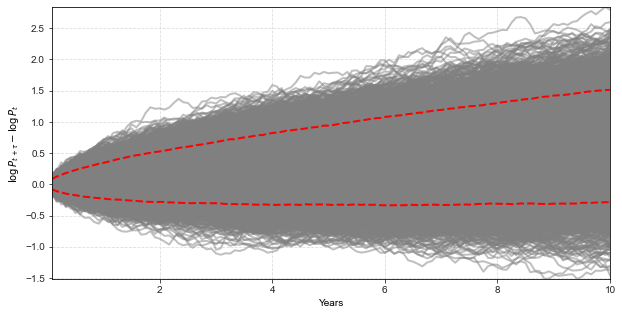

In [22]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(all_years, cum_log_returns.T, color="grey", alpha=0.5);
ax.plot(all_years, percentiles.T, color="red", linestyle="--");
ax.set_xlabel('Years')
ax.set_ylabel("$\\log P_{t + \\tau} - \\log P_{t}$");

The square-root rule holds (increase the number of simulation to get a even better match)

In [23]:
np.std(cum_log_returns[:, -1])

0.5482801630369751

In [24]:
np.sqrt(months) * sigma

0.5477225575051662

__Question 2__

In [25]:
def simulate(mu: float, alpha: float, sigma: float, num_sim: int, months: int):
    
    eps = np.random.normal(loc=0, scale=sigma, size=(num_sim, months))
    long_term = 0 + mu * np.arange(0, months, 1.0)
    
    log_p = np.zeros((num_sim, 1 + months))
    
    for i in range(months):
        
        log_p[:, i + 1] = log_p[:, i] + mu + alpha * (long_term[i] - log_p[:, i]) + eps[:, i]
    
    return log_p[:, 1:] - log_p[:, :-1]

In [26]:
mu = 0.005
alpha = 0.01
sigma = 0.05
num_sim = 10000
months = 120

log_returns_mean_reversion = simulate(mu, alpha, sigma, num_sim, months)
cum_log_returns_mean_reversion = np.cumsum(log_returns_mean_reversion, axis=1)
percentiles_mean_reversion = np.percentile(cum_log_returns_mean_reversion, [5, 95], axis=0)

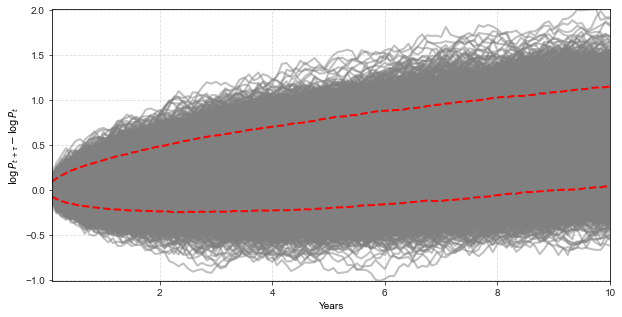

In [27]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(all_years, cum_log_returns_mean_reversion.T, color="grey", alpha=0.5);
ax.plot(all_years, percentiles_mean_reversion.T, color="red", linestyle="--");
ax.set_xlabel('Years')
ax.set_ylabel("$\\log P_{t + \\tau} - \\log P_{t}$");

The square-root rule does not hold! Mean-reversion results in a lower volatility that eventually stops increasing. 

In [28]:
np.std(cum_log_returns_mean_reversion[:, -1])

0.3387766817619936

In [29]:
np.sqrt(months) * sigma

0.5477225575051662

## Problem 3: Nominal yields data 

__Quesition 1__

Load the function `get_nominal_yield_data` from `codelib.dal.fred_yield_data` and check out the docstring.

__Question 2__

Store the zero coupon yields in the data frame `zero_yields`

__Question 3__

Plot the 1-year, 5-year and 10-year yield over time. 

__Question 4__

Use `pandas-datareader` to obtain NBER recession indicators (FRED database, 'USREC'). Add recession indicators to the previous plot.

__Quesition 5__

Plot a 3D plot of the zero coupon yield curves over time from 1986 (drop all dates with NaN).

### Solution 

__Question 1__

In [30]:
%pdoc get_nominal_yield_data

In [31]:
help(get_nominal_yield_data)

Help on function get_nominal_yield_data in module codelib.dal.fred_yield_data:

get_nominal_yield_data(output_type: str = 'zero_yields') -> pandas.core.frame.DataFrame
    Function that returns nominal yield curve data from https://www.federalreserve.gov/data/nominal-yield-curve.htm
    
    Parameters
    ----------
    output_type
        Output type: 'parameters', 'zero_yields', 'par_yield', 'inst_forward', 'one_year_forward'
    
    Returns
    -------
    pd.DataFrame
        DataFrame with observations



__Question 2__

In [32]:
zero_yields = get_nominal_yield_data(output_type='zero_yields')
zero_yields.head()

,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10,...,SVENY21,SVENY22,SVENY23,SVENY24,SVENY25,SVENY26,SVENY27,SVENY28,SVENY29,SVENY30
Date,,,,,,,,,,,,,,,,,,,,,
1961-06-14,2.9825,3.3771,3.5530,3.6439,3.6987,3.7351,3.7612,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-06-15,2.9941,3.4137,3.5981,3.6930,3.7501,3.7882,3.8154,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-06-16,3.0012,3.4142,3.5994,3.6953,3.7531,3.7917,3.8192,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-06-19,2.9949,3.4386,3.6252,3.7199,3.7768,3.8147,3.8418,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-06-20,2.9833,3.4101,3.5986,3.6952,3.7533,3.7921,3.8198,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
zero_yields.columns  = [str(_)+'Y' for _ in range(1, 31)]

__Question 3__

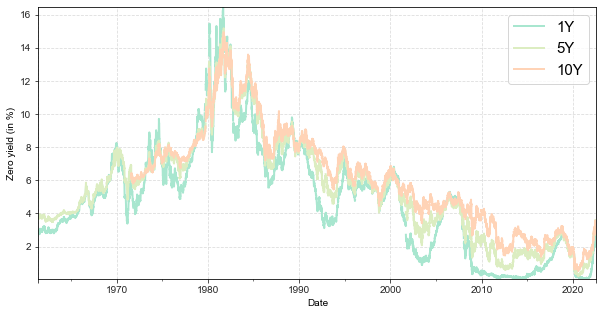

In [34]:
ax = zero_yields[['1Y', '5Y', '10Y']].plot(figsize=(10,5));
ax.set_ylabel('Zero yield (in %)');

__Question 4__

In [35]:
nber_recessions = DataReader('USREC', 'fred', start=datetime.date(1960,1,1))

# get start and end dates of recessions
change_nber = nber_recessions - nber_recessions.shift(1)
start_dates = change_nber[change_nber['USREC']==1.0].index.to_list()
end_dates = change_nber[change_nber['USREC']==-1.0].index.to_list()

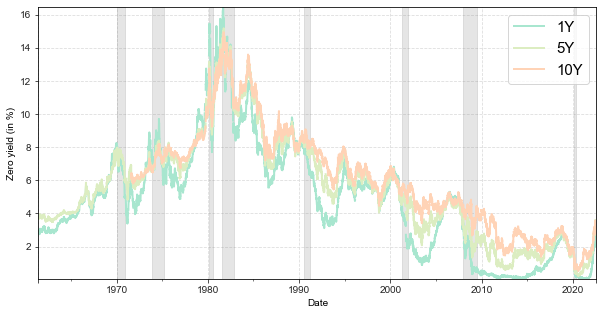

In [36]:
ax = zero_yields[['1Y', '5Y', '10Y']].plot(figsize=(10,5));
ax.set_ylabel('Zero yield (in %)');
for s, e in zip(start_dates, end_dates):
    ax.axvspan(s, e, color="grey", alpha=0.2)


__Question 5__

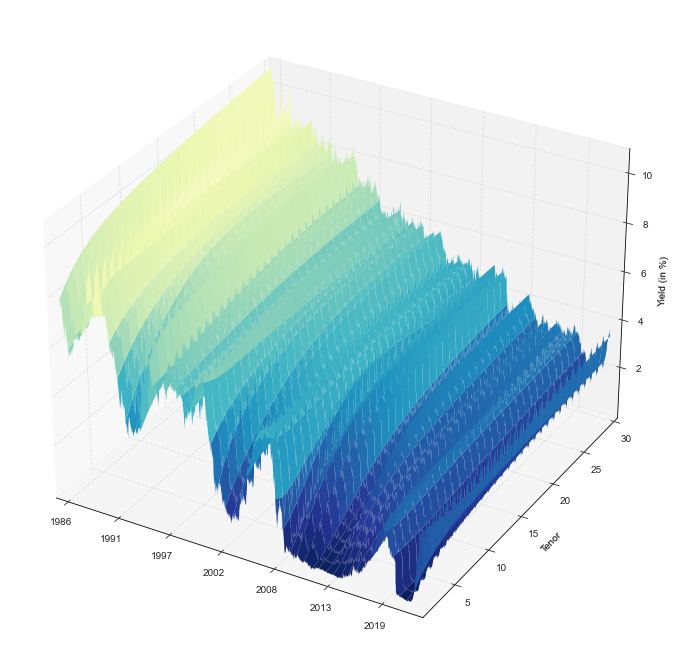

In [37]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import dates, ticker


fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

zero_yields = zero_yields.dropna()

dates_for_plot = np.array(dates.date2num(zero_yields.index.to_list()))
tenors = np.arange(1.0, 31.0, 1.0)

d, t = np.meshgrid(dates_for_plot, tenors)

ax.plot_surface(d, t, zero_yields.T, cmap='YlGnBu_r', vmin=0, vmax=10)
ax.set_xlabel('')
ax.set_ylabel('Tenor')
ax.set_zlabel('Yield (in %)');

ax.w_xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: dates.num2date(x).strftime('%Y')))